### Lab5 - Zastosowanie optymalizatora do dopasowania modelu/rozkładu do danych rzeczywistych

Przygotowanie do dopasowania rozkładu do danych zaczynamy od ponownego pobrania danych z Wikipedii. Jak poprzednio, będą to dane dotyczące największych miast w Europie oraz ludności poszczególnych krajów.

In [7]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

URL = "https://en.wikipedia.org/wiki/List_of_European_cities_by_population_within_city_limits"
resp = requests.get(URL) 
if resp.status_code == 200:
    soup = BeautifulSoup(resp.content,'html.parser')
    tab = soup.find('table',{'class':"wikitable"})
df = pd.read_html(str(tab))[0]
df =df.loc[:, 'City':'Officialpopulation':]
df.replace(to_replace={'[[a]]':"",'[[b]]':""}, regex=True,inplace=True)
df.replace(to_replace='[[,]', value="", regex=True,inplace=True)
for i in range(len(df['Officialpopulation'])):
    df['Officialpopulation'][i] = float("{:.2f}".format(int(df['Officialpopulation'][i])/1000000))
df = df[:15]
import re
URL = "https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population"
resp = requests.get(URL) 
if resp.status_code == 200:
    soup = BeautifulSoup(resp.content,'html.parser')
    tab = soup.find('table',{'class':"wikitable"})
df1 = pd.read_html(str(tab))[0]
pop = dict(zip(df1["Country / Dependency"],df1["Population"]))
i=0
for country in df["Country"]:
    df.at[i,"Countrypopulation"] = float("{:.2f}".format(pop.get(country)/1000000))
    i+=1
df

,City,Country,Officialpopulation,Countrypopulation
0,Istanbul,Turkey,15.84,84.68
1,Moscow,Russia,12.63,147.19
2,London,United Kingdom,9.0,67.08
3,Saint Petersburg,Russia,5.38,147.19
4,Berlin,Germany,3.66,83.22
5,Madrid,Spain,3.31,47.33
6,Kyiv,Ukraine,2.92,41.13
7,Rome,Italy,2.84,58.93
8,Bucharest,Romania,2.16,19.19
9,Paris,France,2.14,67.85


Doświadczenie polega na znalezieniu optymalnych współczynników a i b we wzorze y = ax + b. \
X - Populacja kraju \
Y - Ludność miasta 

Współczynniki a i b będą wyliczane jako minimum funkcji błędu średniokwadratowego

In [8]:
X = df['Countrypopulation'].values
Y = df['Officialpopulation'].values

print('Ludność kraju: %s' % X)
print('Liczba mieszkańców miasta: %s' % Y)

Ludność kraju: [ 84.68 147.19  67.08 147.19  83.22  47.33  41.13  58.93  19.19  67.85
   9.35   9.03  83.22  38.03   9.69]
Liczba mieszkańców miasta: [15.84 12.63 9.0 5.38 3.66 3.31 2.92 2.84 2.16 2.14 2.01 1.93 1.85 1.79
 1.72]


Następnie musimy utworzyć funkcje, dzięki którym przeprowadzimy eksperymenty. \
Przypominając, błąd przybliżenia dla pojedynczej $i$-tej pary pomiarów wynosi:
$$e_i=y_i-\overline{y_i}.$$
A miarę błędu popełnianego przez model na danych $X,Y$ przyjmujemy jako:
\begin{equation}
Q(a,b) = \frac{1}{N}\sqrt{\sum_{i=1}^Ne_i^2}\ .
\tag{3}
\end{equation}


In [9]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import optimize

def funkcja_bledu(x):
    a,b = x
    err = 0
    for i in range(0,X.size):
        err += ( ( Y[i] - ( a * X[i] + b ) ) ) ** 2
    return 1/X.size * np.sqrt(err)

def pokaz_2D(Fcelu, x_historia, zakres):
  x_pocz, x_opt = x_historia[0], x_historia[-1]
  os_x1 = np.linspace(zakres[0], zakres[1], num=100)
  os_x2 = np.linspace(zakres[2], zakres[3], num=100)
  siatka_X1, siatka_X2 = np.meshgrid(os_x1, os_x2)
  macierz_Z = Fcelu([siatka_X1, siatka_X2])

  fig, ax = plt.subplots(figsize=(8,8))
  cplot = ax.contourf(siatka_X1, siatka_X2, macierz_Z, 10, cmap='Spectral_r', alpha=1)
  clines = ax.contour(siatka_X1, siatka_X2, macierz_Z, 10, colors='black')
  for punkt in x_historia:
      ax.plot(punkt[0], punkt[1], 'o', 
              color='white', markeredgecolor='black', markersize=5, alpha=0.7)
  ax.plot(x_pocz[0], x_pocz[1], 'd', 
          color='gray', markeredgecolor='black', markersize=10, alpha=0.7)    
  ax.plot(x_opt[0], x_opt[1], 'h', 
          color='white', markeredgecolor='black', markersize=15)
  ax.set_aspect('equal')
  ax.set_xlabel(r'$x_1$', fontsize=16)
  ax.set_ylabel(r'$x_2$', fontsize=16)
  ax.clabel(clines)
  fig.colorbar(cplot)
  return fig, ax


def model(parametry, x):
  a, b = parametry
  return a*x + b

## Eksperyment 1

Punkt startowy : 49.3522 41.584
Optimization terminated successfully.
         Current function value: 0.884039
         Iterations: 79
         Function evaluations: 149
a = 0.058312
b = 1.062305
Wartość błędu: 0.884039


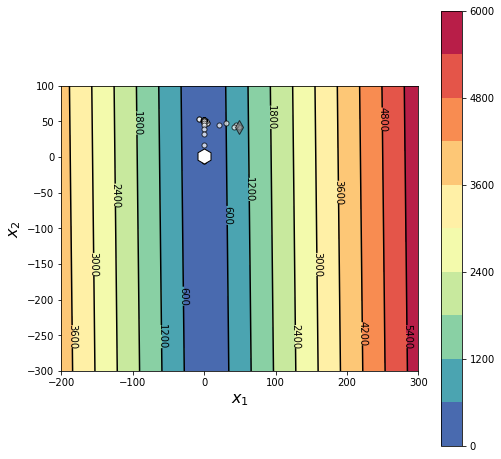

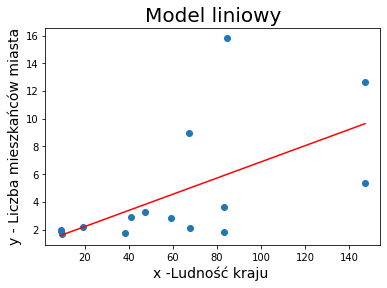

In [10]:
x_pocz = np.random.normal(loc=-10, scale=80, size=2)        
print('Punkt startowy : ' + str(round(x_pocz[0], 4)) + ' ' + str(round(x_pocz[1], 4)))  

x_opt, x_history = optimize.fmin(funkcja_bledu, x_pocz, retall=True)

print('a = %s' % round(x_opt[0], 6))
print('b = %s' % round(x_opt[1], 6))
print('Wartość błędu: ' + str(round(funkcja_bledu(x_opt), 6)))

zakres = [-200, 300, -300, 100]
pokaz_2D(funkcja_bledu, x_history, zakres)
plt.show()
X_test = np.linspace(start = X.min(), stop = X.max(), num = 300)
Y_pred = model(parametry = [x_opt[0], x_opt[1]], x = X_test)
plt.scatter(X,Y)
plt.plot(X_test, Y_pred, color = 'red')
plt.xlabel('x -Ludność kraju ', fontsize = 14)
plt.ylabel('y - Liczba mieszkańców miasta', fontsize = 14)
plt.title('Model liniowy', size = 20)
plt.show()

## Eksperyment 2

Punkt startowy : -83.6417 -11.2855
Optimization terminated successfully.
         Current function value: 0.884039
         Iterations: 79
         Function evaluations: 145
a = 0.058312
b = 1.062324
Wartość błędu: 0.884039


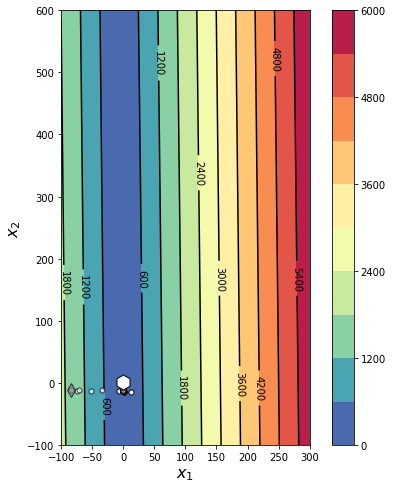

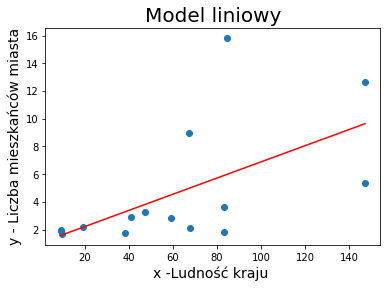

In [11]:
x_pocz = np.random.normal(loc=-2, scale=90, size=2)        
print('Punkt startowy : ' + str(round(x_pocz[0], 4)) + ' ' + str(round(x_pocz[1], 4)))  

x_opt, x_history = optimize.fmin(funkcja_bledu, x_pocz, retall=True)

print('a = %s' % round(x_opt[0], 6))
print('b = %s' % round(x_opt[1], 6))
print('Wartość błędu: ' + str(round(funkcja_bledu(x_opt), 6)))

zakres = [-100, 300, -100,600]
pokaz_2D(funkcja_bledu, x_history, zakres)
plt.show()

X_test = np.linspace(start = X.min(), stop = X.max(), num = 300)
Y_pred = model(parametry = [x_opt[0], x_opt[1]], x = X_test)
plt.scatter(X,Y)
plt.plot(X_test, Y_pred, color = 'red')
plt.xlabel('x -Ludność kraju ', fontsize = 14)
plt.ylabel('y - Liczba mieszkańców miasta', fontsize = 14)
plt.title('Model liniowy', size = 20)
plt.show()

## Eksperyment 3

Punkt startowy : -2.0587 81.5973
Optimization terminated successfully.
         Current function value: 0.884039
         Iterations: 56
         Function evaluations: 110
a = 0.058311
b = 1.062373
Wartość błędu: 0.884039


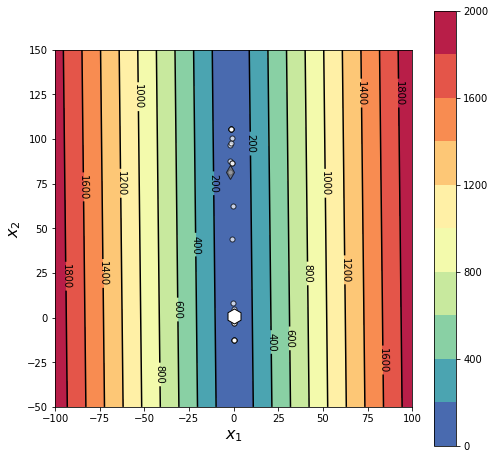

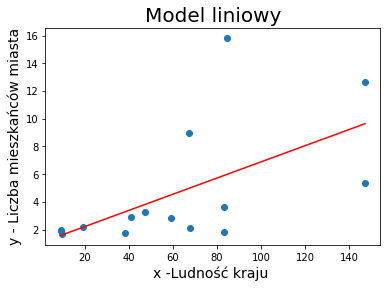

In [12]:
x_pocz = np.random.normal(loc=1, scale=45, size=2)        
print('Punkt startowy : ' + str(round(x_pocz[0], 4)) + ' ' + str(round(x_pocz[1], 4)))  

x_opt, x_history = optimize.fmin(funkcja_bledu, x_pocz, retall=True)

print('a = %s' % round(x_opt[0], 6))
print('b = %s' % round(x_opt[1], 6))
print('Wartość błędu: ' + str(round(funkcja_bledu(x_opt), 6)))

zakres = [-100, 100, -50, 150]
pokaz_2D(funkcja_bledu, x_history, zakres)
plt.show()

X_test = np.linspace(start = X.min(), stop = X.max(), num = 300)
Y_pred = model(parametry = [x_opt[0], x_opt[1]], x = X_test)
plt.scatter(X,Y)
plt.plot(X_test, Y_pred, color = 'red')
plt.xlabel('x -Ludność kraju ', fontsize = 14)
plt.ylabel('y - Liczba mieszkańców miasta', fontsize = 14)
plt.title('Model liniowy', size = 20)
plt.show()

### Wnioski

Eksperymenty przyniosły podobne rezultaty. Dla każdego współczynnik a był taki sam, i wynosił: a = 0.059026. Natomiast współczynnik b różnił się nieznacząco odpowiednio: b = 1.032313, b = 1.032254, b = 1.032264. Można zauważyć, że poszczególne parametry różnią się dopiero po 4 miejscu po przecinku.
Wynika z tego, że dla przyjętych przeze mnie danych, funkcja błędu ma jedno optimum globalne, a metoda Neldera-Meada do niego dąży. 
W metodzie numerycznej ważną rolę odgrywa odpowiednio dobrany punkt startowy.
